In [9]:
import numpy as np
from matplotlib import pyplot as plt
import math

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from scipy.special import hermite, factorial

from pde_classes import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using device {device}")

Using device mps


Epoch 0, E = 157.9127, loss = 3.249e+06, lr = 1.0e-03
Epoch 1000, E = 157.1958, loss = 8.871e+03, lr = 1.0e-03
Epoch 2000, E = 156.2867, loss = 8.755e+03, lr = 1.0e-03
Epoch 3000, E = 155.3211, loss = 8.571e+03, lr = 1.0e-03
Epoch 4000, E = 154.4842, loss = 2.397e+03, lr = 1.0e-03
Epoch 5000, E = 154.2286, loss = 6.657e+02, lr = 1.0e-03
Epoch 6000, E = 154.1498, loss = 6.662e+00, lr = 1.0e-03
Epoch 7000, E = 154.1510, loss = 1.454e+00, lr = 1.0e-03
Epoch 8000, E = 154.1663, loss = 1.043e+00, lr = 1.0e-03
Epoch 9000, E = 154.1893, loss = 1.010e+00, lr = 1.0e-03


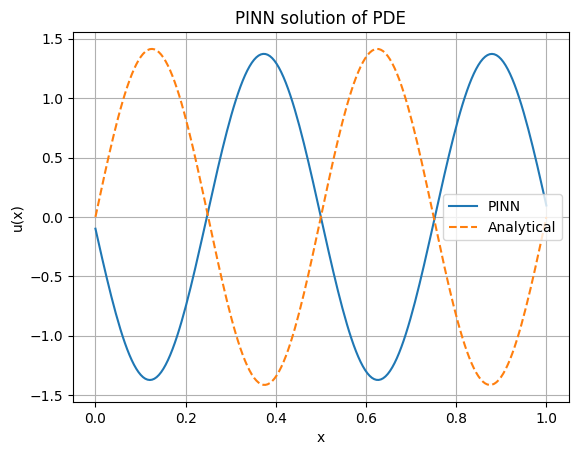

In [ ]:

pinn = tiSchrodingerI(
    device=device, 
    num_points=100, 
    state=4,
    loss_pde_factor = 1,
    loss_bc_factor = 100,
    loss_norm_factor = 1,
    loss_norm_exp_factor = 10
    ).to(device)

pinn.apply(init_weights)
optimizer = torch.optim.Adam(
    list(pinn.net.parameters()) + [pinn.E],
    lr=1e-3
)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(
#     optimizer, milestones=[8000], gamma=0.1  # At epoch 8000, lr *= 0.1
# )

epochs = 10000
num_batches = 1

dataset = TensorDataset(pinn.x_interior)
batch_size = int(len(dataset) / num_batches)
dataloader = DataLoader(dataset, batch_size, shuffle=True)

for epoch in range(epochs):
    for (x_batch,) in dataloader:
        optimizer.zero_grad()
        loss = pinn.loss(x_batch)
        loss.backward()
        optimizer.step()
    # scheduler.step()  # Step the scheduler at the end of each epoch

    if epoch % (epochs/10) == 0:
        print(f"Epoch {epoch}, E = {pinn.E.item():.4f}, loss = {loss.item():.3e}, lr = {optimizer.param_groups[0]['lr']:.1e}")



# Evaluate
u_pred = pinn(pinn.x_test).detach().cpu().numpy()

# Plot
plt.plot(pinn.x_test.cpu(), u_pred, label="PINN")
plt.plot(pinn.x_test.cpu(), pinn.u_true, '--', label="Analytical")
plt.legend()
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title("PINN solution of PDE")
plt.grid(True)
plt.show()

# print(pinn.x_t)
# print(pinn.y)